In [50]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 21 15:52:58 2017

@author: meenakshi
"""

import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing/"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "housing.tgz"

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path = housing_path)
    housing_tgz.close()
    
fetch_housing_data(HOUSING_URL, HOUSING_PATH)

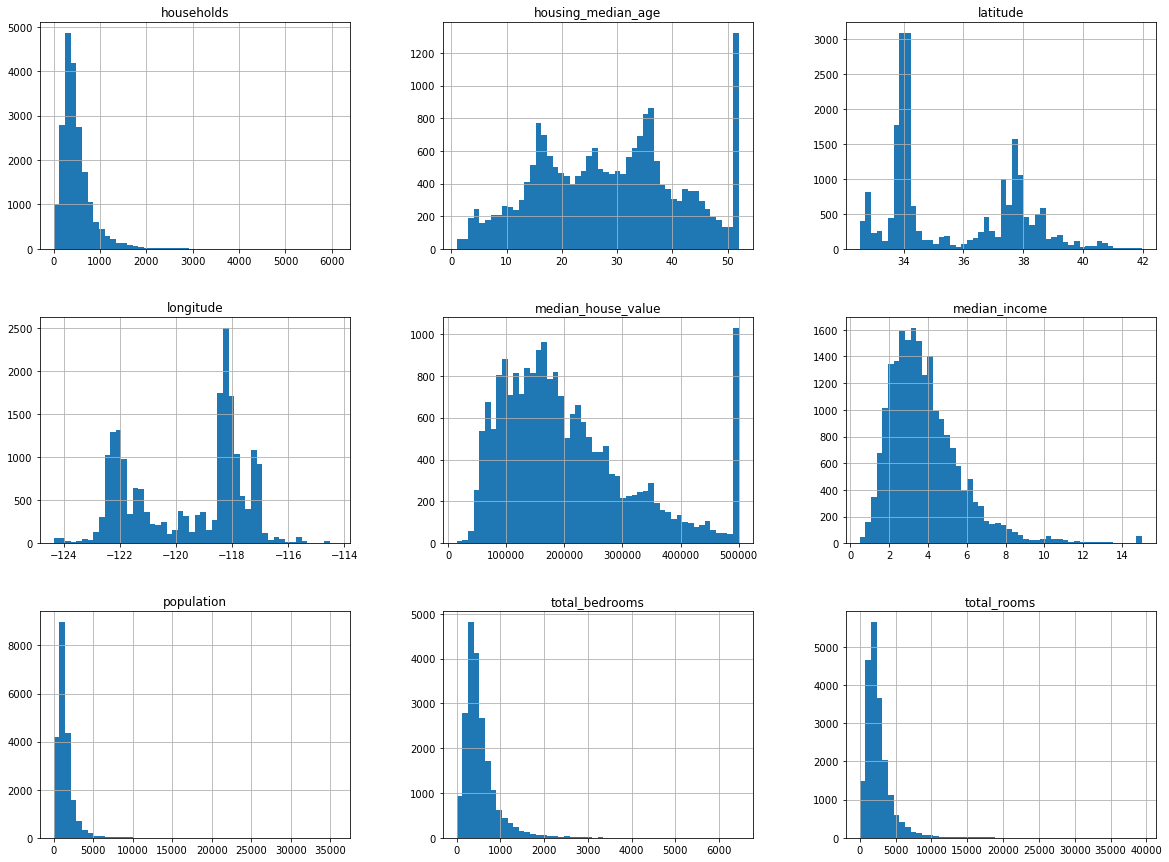

In [51]:
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 21 16:14:51 2017

@author: meenakshi
"""

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hashlib
from sklearn.model_selection import train_test_split

HOUSING_PATH = "datasets/housing/"

housing = pd.read_csv(HOUSING_PATH + "housing.csv")
housing.hist(bins = 50, figsize = (20,15))
plt.show()

def split_train_test(data, test_ratio):
    #np.random.seed(42) to fix the permutation for different runs
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_ind = shuffled_indices[:test_size]
    train_ind = shuffled_indices[test_size:]
    return data.iloc[test_ind], data.iloc[train_ind]
    
test_set, train_set = split_train_test(housing, 0.2)

def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256*test_ratio
    
def test_train_split_hash(data, test_ratio, id_col, hash = hashlib.md5):
    ids = data[id_col]
    test_set_id = ids.apply(lambda idval:test_set_check(idval, test_ratio, hash))
    return data.loc[test_set_id], data.loc[~test_set_id]
    
housing.reset_index(inplace = True)

test_set, train_set = test_train_split_hash(housing, 0.2, "index")





In [52]:
housing['median_income_binned'] = np.ceil(housing['median_income']/1.5)
housing.columns

Index(['index', 'longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'median_income_binned'],
      dtype='object')

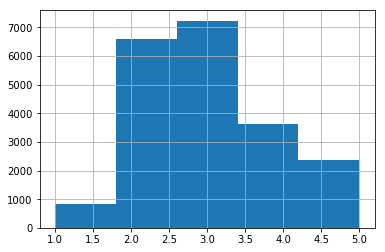

In [53]:
housing['median_income_binned'].where(housing['median_income_binned'] < 5, 5.0, inplace = True)
housing['median_income_binned'].hist(bins = 5)
plt.show()

In [54]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

In [55]:
for train_idx, test_idx in split.split(housing, housing['median_income_binned']):
    strat_train_set = housing.loc[train_idx]
    strat_test_set = housing.loc[test_idx]

In [56]:
housing["median_income_binned"].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: median_income_binned, dtype: float64

In [57]:
strat_test_set["median_income_binned"].value_counts()/len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: median_income_binned, dtype: float64

In [58]:
strat_train_set.drop("median_income_binned", axis = 1, inplace = True)
strat_test_set.drop("median_income_binned", axis = 1, inplace = True)

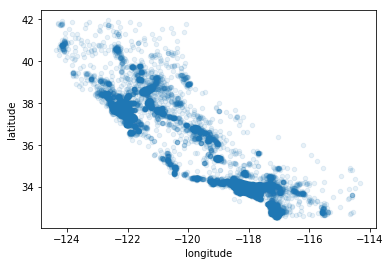

In [59]:
housing = strat_train_set.copy()
housing.plot(kind = "scatter", x = 'longitude', y = 'latitude', alpha = 0.1)
plt.show()

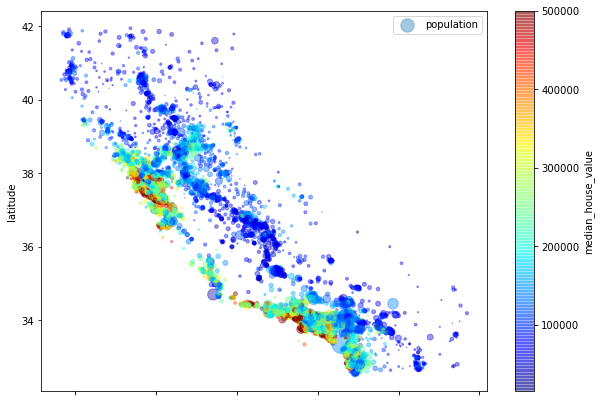

In [60]:
housing.plot(kind = 'scatter', x = 'longitude', y = 'latitude', alpha = 0.4, s = housing['population']/100, label = 'population', figsize = (10, 7), c = 'median_house_value', cmap = plt.get_cmap('jet'), colorbar = True)
plt.show()

In [61]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
index                 0.067723
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

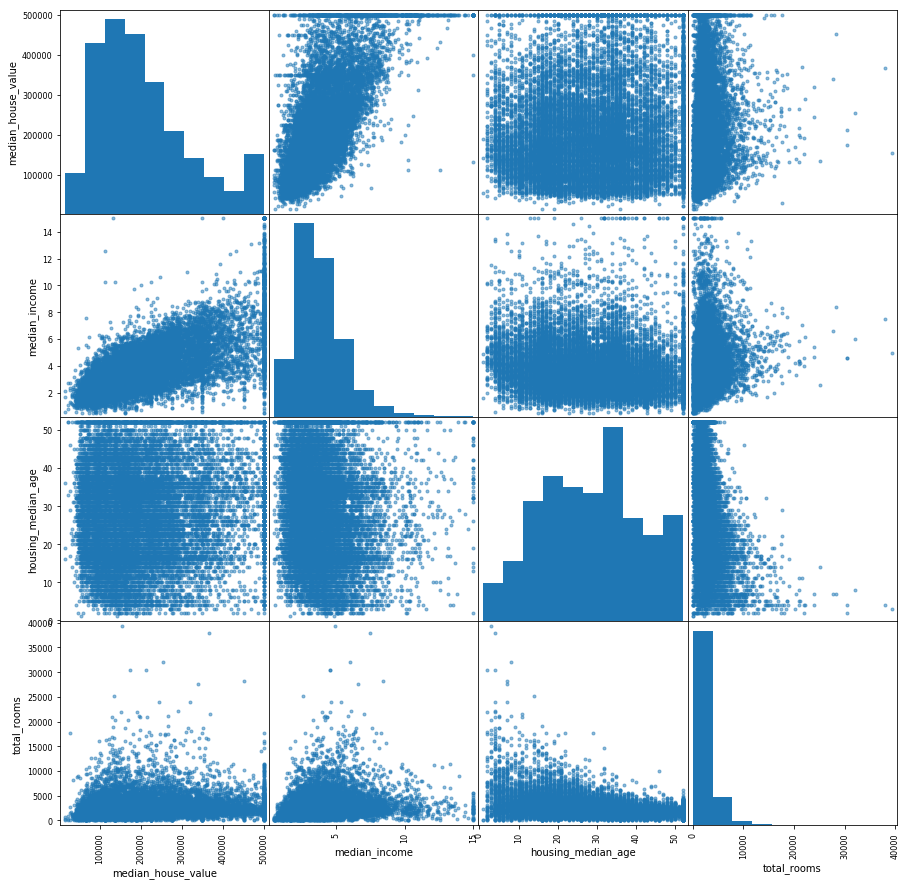

In [62]:
from pandas.tools.plotting import scatter_matrix

to_plot = ['median_house_value', 'median_income', 'housing_median_age', 'total_rooms']
scatter_matrix(housing[to_plot], figsize = (15,15))
plt.show()

In [63]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy = "median", axis = 1)
ocean_proximity = housing['ocean_proximity']
housing.drop('ocean_proximity', axis = 1, inplace = True)
imputer.fit(housing)

Imputer(axis=1, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [64]:
X = imputer.transform(housing)
housing = pd.DataFrame(X, columns = housing.columns)

In [65]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
ocean_lab_enc = encoder.fit_transform(ocean_proximity.tolist())
print(encoder.classes_)
ocean_lab_enc

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [73]:
from sklearn.preprocessing import OneHotEncoder
encoder2 = OneHotEncoder()
ocean_lab_enc2 = encoder2.fit_transform(ocean_lab_enc.reshape(-1,1))
ocean_lab_enc2

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [74]:
from sklearn.preprocessing import LabelBinarizer
encoder3 = LabelBinarizer()
ocean_lab_enc3 = encoder3.fit_transform(ocean_proximity)
ocean_lab_enc3

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [90]:
#all data preparation

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ind, bedrooms_ind, population_ind, household_ind = 3, 4, 5, 6

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        rooms_per_household = X[:, rooms_ind]/X[:, household_ind]
        pop_per_household = X[:, population_ind]/X[:, household_ind]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:,bedrooms_ind]/X[:, rooms_ind]
            return np.c_[X, rooms_per_household, pop_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, pop_per_household]
        
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [113]:
housing = strat_train_set.copy()
housing_labels = housing['median_house_value']
housing.drop(['median_house_value'], axis = 1, inplace = True)
housing_num_attrib = list(housing._get_numeric_data())
housing_cat_attrib = list(set(list(housing)) - set(list(housing._get_numeric_data())))

In [114]:
#all data preparation

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('datatransform', DataFrameSelector(housing_num_attrib)),
    ('imputer', Imputer(strategy='median')),
    ('attribute_add', AttributesAdder()),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('datatransform', DataFrameSelector(housing_cat_attrib)),
    ('one_hot_encode', LabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list = [
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])


housing_tr = full_pipeline.fit_transform(housing)

In [115]:
housing_tr.shape

(16512, 17)

In [116]:
#training models

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_tr, housing_labels)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [119]:
housing_predict = lin_reg.predict(housing_tr)

from sklearn.metrics import mean_squared_error

lin_reg_mse = mean_squared_error(housing_predict, housing_labels)
print(np.sqrt(lin_reg_mse))

68336.8412137


In [121]:
from sklearn.tree import DecisionTreeRegressor

dectree_reg = DecisionTreeRegressor()
dectree_reg.fit(housing_tr, housing_labels)

dec_tree_pred = dectree_reg.predict(housing_tr)
dec_tree_mse = mean_squared_error(dec_tree_pred, housing_labels)
print(np.sqrt(dec_tree_mse))

0.0


In [124]:
from sklearn.model_selection import cross_val_score
scoretree = cross_val_score(dectree_reg, housing_tr, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
dec_tree_rmse = np.sqrt(-scoretree)

def display_scores(scores):
    print("Scores:", scores)
    print("Avg:", scores.mean())
    print("Std Dev:", scores.std())
    
display_scores(dec_tree_rmse)

Scores: [ 63788.98791774  64880.61968117  69420.91882826  70330.77643475
  70549.44902439  74287.43960798  64102.92622503  67938.62004809
  70647.72945715  72470.94981249]
Avg: 68841.8417037
Std Dev: 3406.61287875


In [126]:
lin_reg_scores = cross_val_score(lin_reg, housing_tr, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
lin_reg_rmse = np.sqrt(-lin_reg_scores)
display_scores(lin_reg_rmse)

Scores: [ 66617.81804036  66540.12916648  69477.2398685   72751.84170316
  68577.12555988  70958.75086775  64965.58233671  68164.98270895
  70923.21069497  67302.51924293]
Avg: 68627.920019
Std Dev: 2285.05759558


In [127]:
from sklearn.ensemble import RandomForestRegressor
rdm_for_reg = RandomForestRegressor()
rdm_for_scores = cross_val_score(rdm_for_reg, housing_tr, housing_labels, scoring = "neg_mean_squared_error", cv = 10)
rdm_for_rmse = np.sqrt(-rdm_for_scores)
display_scores(rdm_for_rmse)

Scores: [ 50715.8554156   48599.15461402  53143.05570537  54178.91980782
  52089.93753908  55621.34410046  49974.65142208  50877.6254923
  56848.85692506  53258.69834295]
Avg: 52530.8099365
Std Dev: 2450.12593333


In [128]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators':[3, 10], 'max_features':[2, 3, 4]},
]

randforest_reg = RandomForestRegressor()
grid_search = GridSearchCV(randforest_reg, param_grid, cv = 5, scoring = 'neg_mean_squared_error')
grid_search.fit(housing_tr, housing_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [132]:
grid_search.best_params_
res = grid_search.cv_results_

for meanscore, paramval in zip(res['mean_test_score'], res['params']):
    print(np.sqrt(-meanscore), paramval)
    

64162.4817785 {'max_features': 2, 'n_estimators': 3}
54776.7781619 {'max_features': 2, 'n_estimators': 10}
51771.6491373 {'max_features': 2, 'n_estimators': 30}
58864.548458 {'max_features': 4, 'n_estimators': 3}
51262.4331239 {'max_features': 4, 'n_estimators': 10}
48730.5916427 {'max_features': 4, 'n_estimators': 30}
56568.8876067 {'max_features': 6, 'n_estimators': 3}
50882.1471966 {'max_features': 6, 'n_estimators': 10}
48225.0458777 {'max_features': 6, 'n_estimators': 30}
56701.4906255 {'max_features': 8, 'n_estimators': 3}
50958.0518474 {'max_features': 8, 'n_estimators': 10}
48592.8567244 {'max_features': 8, 'n_estimators': 30}
60767.2118971 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53270.2356371 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59299.8714427 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
51125.651299 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58124.8778965 {'bootstrap': False, 'max_features': 4, 'n_estimat

dict

In [135]:
#prediction
housing_test = strat_test_set.copy()
housing_test_labels = housing_test['median_house_value']
housing_test.drop(['median_house_value'], axis = 1, inplace = True)

housing_tst = full_pipeline.transform(housing_test)
best_est = grid_search.best_estimator_

test_predict = best_est.predict(housing_tst)
test_err = mean_squared_error(test_predict, housing_test_labels)
print('err on test set:', np.sqrt(test_err))


err on test set: 46112.8008263
